# Dynamic Pricing for Urban Parking Lots
# Notebook 2: Feature Engineering & Preparation

This notebook creates advanced features for pricing models including:
- Proximity calculations between parking lots
- Demand indicators
- Historical patterns
- Competitor pricing features

# 1. IMPORT LIBRARIES

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

print("Libraries imported successfully!")

Libraries imported successfully!


# 2. LOAD PROCESSED DATA

In [3]:
data = pd.read_csv('processed_data.csv')
data['DateTime'] = pd.to_datetime(data['DateTime'])

print(f"Loaded dataset shape: {data.shape}")
print(f"\nColumns: {list(data.columns)}")

Loaded dataset shape: (18368, 23)

Columns: ['ID', 'SystemCodeNumber', 'Capacity', 'Latitude', 'Longitude', 'Occupancy', 'VehicleType', 'TrafficConditionNearby', 'QueueLength', 'IsSpecialDay', 'LastUpdatedDate', 'LastUpdatedTime', 'DateTime', 'Date', 'Time', 'Hour', 'Minute', 'DayOfWeek', 'DayName', 'WeekOfYear', 'OccupancyRate', 'VehicleType_Encoded', 'TrafficLevel_Encoded']


# 3. HAVERSINE DISTANCE CALCULATION 

In [4]:
def haversine_distance(lat1, lon1, lat2, lon2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    
    Returns distance in kilometers
    """
    # Convert decimal degrees to radians
    lat1_rad = np.radians(lat1)
    lon1_rad = np.radians(lon1)
    lat2_rad = np.radians(lat2)
    lon2_rad = np.radians(lon2)
    
    # Haversine formula
    dlat = lat2_rad - lat1_rad
    dlon = lon2_rad - lon1_rad
    
    a = np.sin(dlat/2)**2 + np.cos(lat1_rad) * np.cos(lat2_rad) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    
    # Radius of earth in kilometers
    r = 6371
    
    return c * r

print("✓ Haversine distance function created")

✓ Haversine distance function created


# 4. CREATE PROXIMITY MATRIX

In [5]:
# Get unique parking lots with their coordinates
parking_lots = data.groupby('SystemCodeNumber').agg({
    'Latitude': 'first',
    'Longitude': 'first',
    'Capacity': 'first'
}).reset_index()

parking_lots['LotID'] = range(len(parking_lots))

print(f"\n{'='*70}")
print(f"PARKING LOT LOCATIONS")
print(f"{'='*70}")
print(parking_lots)



PARKING LOT LOCATIONS
    SystemCodeNumber   Latitude  Longitude  Capacity  LotID
0        BHMBCCMKT01  26.144536  91.736172       577      0
1        BHMBCCTHL01  26.144495  91.736205       387      1
2        BHMEURBRD01  26.149020  91.739503       470      2
3        BHMMBMMBX01  20.000035  78.000003       687      3
4        BHMNCPHST01  26.140014  91.731000      1200      4
5        BHMNCPNST01  26.140048  91.730972       485      5
6       Broad Street  26.137958  91.740994       690      6
7   Others-CCCPS105a  26.147473  91.728049      2009      7
8   Others-CCCPS119a  26.147541  91.727970      2803      8
9   Others-CCCPS135a  26.147499  91.728005      3883      9
10   Others-CCCPS202  26.147491  91.727997      2937     10
11     Others-CCCPS8  26.147549  91.727995      1322     11
12    Others-CCCPS98  26.147500  91.727978      3103     12
13          Shopping  26.150504  91.733531      1920     13


In [6]:
# Create distance matrix
n_lots = len(parking_lots)
distance_matrix = np.zeros((n_lots, n_lots))

for i in range(n_lots):
    for j in range(n_lots):
        if i != j:
            distance_matrix[i, j] = haversine_distance(
                parking_lots.iloc[i]['Latitude'],
                parking_lots.iloc[i]['Longitude'],
                parking_lots.iloc[j]['Latitude'],
                parking_lots.iloc[j]['Longitude']
            )


In [7]:
# Create DataFrame for better visualization
distance_df = pd.DataFrame(
    distance_matrix,
    index=[f"Lot_{i}" for i in range(n_lots)],
    columns=[f"Lot_{i}" for i in range(n_lots)]
)

print(f"\n{'='*70}")
print(f"DISTANCE MATRIX (in kilometers)")
print(f"{'='*70}")
print(distance_df.round(2))



# Save distance matrix
np.save('distance_matrix.npy', distance_matrix)
parking_lots.to_csv('parking_lot_info.csv', index=False)

print(f"\n✓ Distance matrix saved")


DISTANCE MATRIX (in kilometers)
          Lot_0    Lot_1    Lot_2    Lot_3    Lot_4    Lot_5    Lot_6  \
Lot_0      0.00     0.01     0.60  1561.11     0.72     0.72     0.88   
Lot_1      0.01     0.00     0.60  1561.11     0.72     0.72     0.87   
Lot_2      0.60     0.60     0.00  1561.61     1.31     1.31     1.24   
Lot_3   1561.11  1561.11  1561.61     0.00  1560.44  1560.44  1561.27   
Lot_4      0.72     0.72     1.31  1560.44     0.00     0.00     1.02   
Lot_5      0.72     0.72     1.31  1560.44     0.00     0.00     1.03   
Lot_6      0.88     0.87     1.24  1561.27     1.02     1.03     0.00   
Lot_7      0.87     0.88     1.16  1560.49     0.88     0.88     1.67   
Lot_8      0.88     0.89     1.16  1560.49     0.89     0.89     1.68   
Lot_9      0.88     0.88     1.16  1560.49     0.88     0.88     1.68   
Lot_10     0.88     0.88     1.16  1560.49     0.88     0.88     1.68   
Lot_11     0.88     0.89     1.16  1560.49     0.89     0.89     1.68   
Lot_12     0.88   

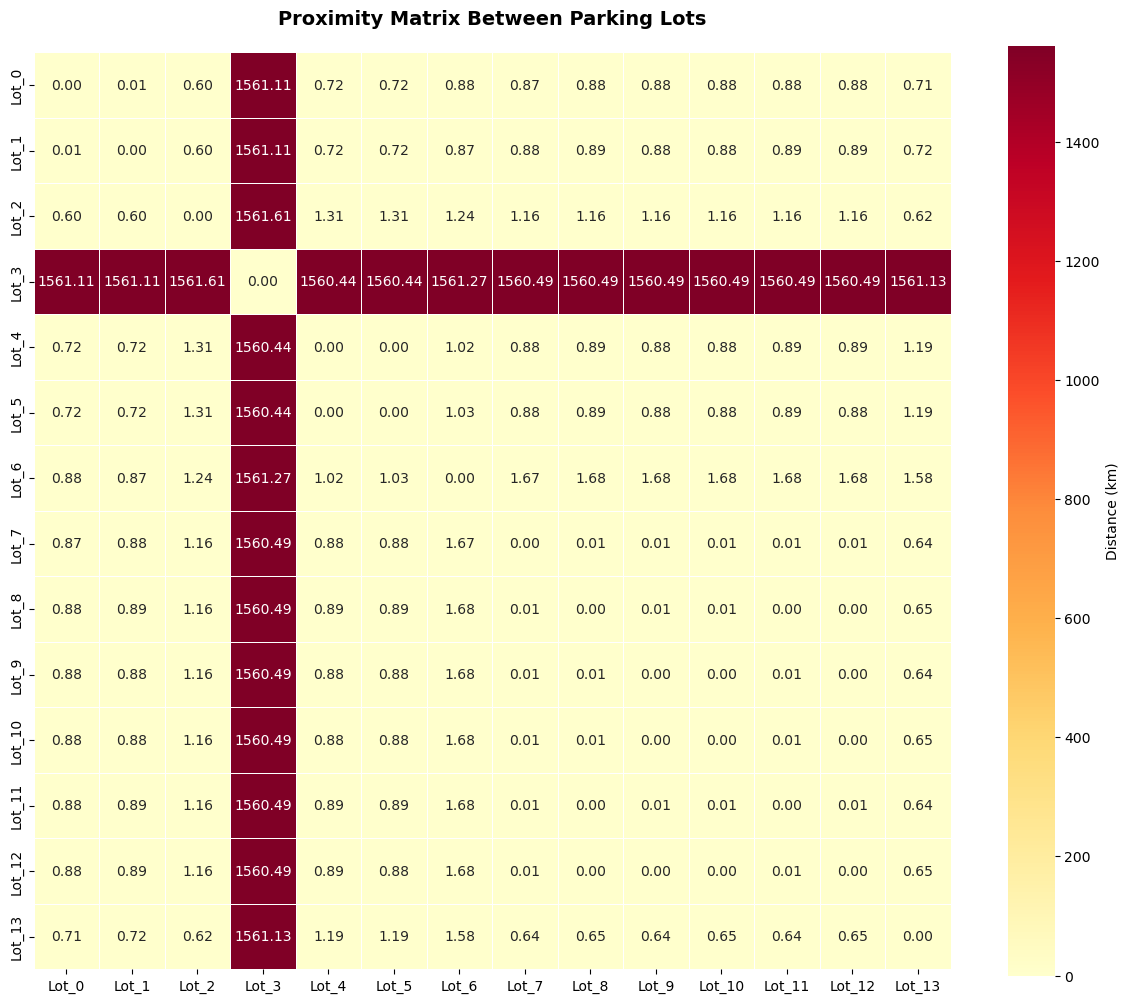

✓ Proximity visualization saved


In [8]:
# Visualize proximity
plt.figure(figsize=(12, 10))
sns.heatmap(distance_df, annot=True, fmt='.2f', cmap='YlOrRd', 
            square=True, linewidths=0.5, cbar_kws={"label": "Distance (km)"})
plt.title('Proximity Matrix Between Parking Lots', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig('figures/05_proximity_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Proximity visualization saved")

# 5. IDENTIFY NEARBY COMPETITORS

In [9]:
def get_nearby_competitors(lot_id, distance_matrix, max_distance_km=2.0):
    """
    Get list of competitor parking lots within specified distance
    
    Parameters:
    - lot_id: ID of the parking lot
    - distance_matrix: numpy array of distances
    - max_distance_km: maximum distance to consider as competitor
    
    Returns:
    - List of nearby competitor lot IDs
    """
    distances = distance_matrix[lot_id]
    nearby = np.where((distances > 0) & (distances <= max_distance_km))[0]
    return list(nearby)



# Create competitor mapping
competitor_map = {}
for i in range(n_lots):
    competitor_map[i] = get_nearby_competitors(i, distance_matrix, max_distance_km=5.0)

print(f"\n{'='*70}")
print(f"COMPETITOR MAPPING (within 5 km)")
print(f"{'='*70}")
for lot_id, competitors in competitor_map.items():
    if competitors:
        print(f"Lot {lot_id}: Competitors = {competitors} "
              f"(Distances: {[f'{distance_matrix[lot_id][c]:.2f}km' for c in competitors]})")
    else:
        print(f"Lot {lot_id}: No nearby competitors")
        
        





COMPETITOR MAPPING (within 5 km)
Lot 0: Competitors = [1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13] (Distances: ['0.01km', '0.60km', '0.72km', '0.72km', '0.88km', '0.87km', '0.88km', '0.88km', '0.88km', '0.88km', '0.88km', '0.71km'])
Lot 1: Competitors = [0, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13] (Distances: ['0.01km', '0.60km', '0.72km', '0.72km', '0.87km', '0.88km', '0.89km', '0.88km', '0.88km', '0.89km', '0.89km', '0.72km'])
Lot 2: Competitors = [0, 1, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13] (Distances: ['0.60km', '0.60km', '1.31km', '1.31km', '1.24km', '1.16km', '1.16km', '1.16km', '1.16km', '1.16km', '1.16km', '0.62km'])
Lot 3: No nearby competitors
Lot 4: Competitors = [0, 1, 2, 5, 6, 7, 8, 9, 10, 11, 12, 13] (Distances: ['0.72km', '0.72km', '1.31km', '0.00km', '1.02km', '0.88km', '0.89km', '0.88km', '0.88km', '0.89km', '0.89km', '1.19km'])
Lot 5: Competitors = [0, 1, 2, 4, 6, 7, 8, 9, 10, 11, 12, 13] (Distances: ['0.72km', '0.72km', '1.31km', '0.00km', '1.03km', '0.88km', '0.89km', '0.88km'

In [10]:
# Save competitor map (FIX for numpy int64 issue)
import json

# Convert numpy int64 to regular Python int
competitor_map_serializable = {
    int(k): [int(v) for v in vals] 
    for k, vals in competitor_map.items()
}

with open('competitor_map.json', 'w') as f:
    json.dump(competitor_map_serializable, f)

print(f"\n✓ Competitor mapping saved")


✓ Competitor mapping saved


# 6. ADVANCED FEATURE ENGINEERING

In [11]:
print(f"\n{'='*70}")
print(f"CREATING ADVANCED FEATURES")
print(f"{'='*70}")

# Create mapping from SystemCodeNumber to LotID
system_to_lot = dict(zip(parking_lots['SystemCodeNumber'], parking_lots['LotID']))
data['LotID'] = data['SystemCodeNumber'].map(system_to_lot)

# 6.1 Occupancy-based features
data['IsNearFull'] = (data['OccupancyRate'] >= 80).astype(int)
data['IsFull'] = (data['OccupancyRate'] >= 95).astype(int)
data['AvailableSpaces'] = data['Capacity'] - data['Occupancy']
data['UtilizationScore'] = data['OccupancyRate'] / 100

print("✓ Occupancy features created")

# 6.2 Time-based features
data['IsPeakHour'] = data['Hour'].isin([8, 9, 10, 11, 12, 13, 14, 15, 16]).astype(int)
data['IsWeekend'] = (data['DayOfWeek'] >= 5).astype(int)
data['TimeSlot'] = pd.cut(data['Hour'], bins=[0, 6, 12, 18, 24], 
                          labels=['Night', 'Morning', 'Afternoon', 'Evening'])

print("✓ Temporal features created")

# 6.3 Demand pressure features
data['DemandPressure'] = (
    0.4 * data['OccupancyRate'] / 100 +
    0.3 * np.minimum(data['QueueLength'] / 10, 1) +
    0.2 * (data['TrafficLevel_Encoded'] - 1) / 2 +
    0.1 * data['IsSpecialDay']
)

print("✓ Demand pressure metric created")

# 6.4 Vehicle type weights (larger vehicles = higher price multiplier)
vehicle_weights = {
    'cycle': 0.5,
    'bike': 0.7,
    'car': 1.0,
    'truck': 1.5
}
data['VehicleWeight'] = data['VehicleType'].map(vehicle_weights)

print("✓ Vehicle weight features created")

# 6.5 Traffic multipliers
traffic_multipliers = {
    'low': 0.9,
    'average': 1.0,
    'high': 1.2
}
data['TrafficMultiplier'] = data['TrafficConditionNearby'].map(traffic_multipliers)

print("✓ Traffic multiplier features created")

# 6.6 Historical rolling features (for time-series patterns)
# Sort by parking lot and time
data = data.sort_values(['LotID', 'DateTime']).reset_index(drop=True)

# Calculate rolling averages for each parking lot
rolling_features = []

for lot_id in data['LotID'].unique():
    lot_data = data[data['LotID'] == lot_id].copy()
    
    # Rolling average occupancy (last 3 time periods = 1.5 hours)
    lot_data['OccupancyRate_MA3'] = lot_data['OccupancyRate'].rolling(
        window=3, min_periods=1
    ).mean()
    
    # Rolling average queue
    lot_data['QueueLength_MA3'] = lot_data['QueueLength'].rolling(
        window=3, min_periods=1
    ).mean()
    
    # Occupancy trend (current vs rolling average)
    lot_data['OccupancyTrend'] = lot_data['OccupancyRate'] - lot_data['OccupancyRate_MA3']
    
    rolling_features.append(lot_data)

data = pd.concat(rolling_features, ignore_index=True)

print("✓ Rolling average features created")



CREATING ADVANCED FEATURES
✓ Occupancy features created
✓ Temporal features created
✓ Demand pressure metric created
✓ Vehicle weight features created
✓ Traffic multiplier features created
✓ Rolling average features created


# 7. CALCULATE BASELINE STATISTICS FOR PRICING

In [12]:
print(f"\n{'='*70}")
print(f"BASELINE PRICING STATISTICS")
print(f"{'='*70}")

# Calculate average occupancy by hour for each parking lot
baseline_occupancy = data.groupby(['LotID', 'Hour'])['OccupancyRate'].mean().reset_index()
baseline_occupancy.columns = ['LotID', 'Hour', 'BaselineOccupancy']

# Merge back to main dataset
data = data.merge(baseline_occupancy, on=['LotID', 'Hour'], how='left')

print("✓ Baseline occupancy patterns calculated")
print(f"\nVerifying BaselineOccupancy column exists: {'BaselineOccupancy' in data.columns}")


# Calculate demand elasticity proxy
lot_stats = data.groupby('LotID').agg({
    'OccupancyRate': ['mean', 'std', 'min', 'max'],
    'QueueLength': ['mean', 'max'],
    'Capacity': 'first'
}).round(2)

lot_stats.columns = ['_'.join(col) for col in lot_stats.columns]

print("\nParking Lot Statistics:")
print(lot_stats)



BASELINE PRICING STATISTICS
✓ Baseline occupancy patterns calculated

Verifying BaselineOccupancy column exists: True

Parking Lot Statistics:
       OccupancyRate_mean  OccupancyRate_std  OccupancyRate_min  \
LotID                                                             
0                   28.08              17.23               0.35   
1                   74.51              23.86              10.08   
2                   64.36              29.23               5.96   
3                   69.48              17.57              24.75   
4                   46.47              18.79               4.58   
5                   58.96              11.82              28.04   
6                   63.21              29.77               6.96   
7                   56.67              13.60              22.50   
8                   19.27               8.77               1.82   
9                   59.04              22.76              12.16   
10                  34.42              10.03        

# 8. FEATURE IMPORTANCE ANALYSIS


FEATURE CORRELATION WITH DEMAND

Correlation with Queue Length (Demand Proxy):
QueueLength             1.000000
DemandPressure          0.871448
TrafficLevel_Encoded    0.866594
OccupancyRate           0.261035
IsSpecialDay            0.180106
Hour                    0.171049
IsPeakHour              0.160706
IsWeekend               0.084503
VehicleType_Encoded    -0.012513
Name: QueueLength, dtype: float64


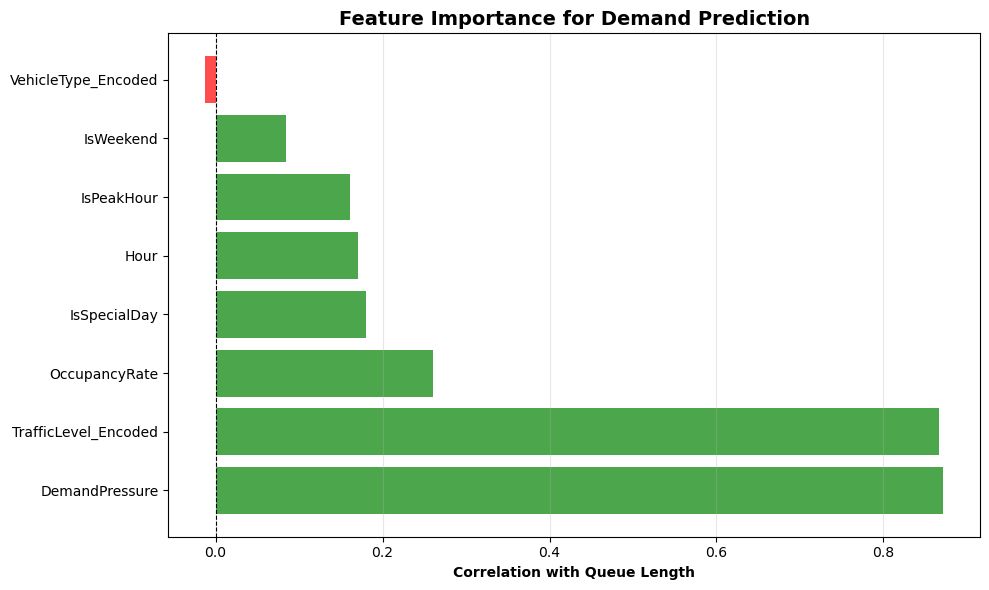

✓ Feature importance analysis saved


In [13]:
print(f"\n{'='*70}")
print(f"FEATURE CORRELATION WITH DEMAND")
print(f"{'='*70}")

# Features to analyze
demand_features = [
    'OccupancyRate', 'QueueLength', 'TrafficLevel_Encoded',
    'IsSpecialDay', 'VehicleType_Encoded', 'Hour',
    'IsWeekend', 'IsPeakHour', 'DemandPressure'
]

# Calculate correlation with queue length (proxy for unmet demand)
correlations = data[demand_features].corr()['QueueLength'].sort_values(ascending=False)

print("\nCorrelation with Queue Length (Demand Proxy):")
print(correlations)

# Visualize feature importance
plt.figure(figsize=(10, 6))
correlations_plot = correlations.drop('QueueLength')
colors = ['green' if x > 0 else 'red' for x in correlations_plot.values]
plt.barh(range(len(correlations_plot)), correlations_plot.values, color=colors, alpha=0.7)
plt.yticks(range(len(correlations_plot)), correlations_plot.index)
plt.xlabel('Correlation with Queue Length', fontweight='bold')
plt.title('Feature Importance for Demand Prediction', fontsize=14, fontweight='bold')
plt.axvline(x=0, color='black', linestyle='--', linewidth=0.8)
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.savefig('figures/06_feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Feature importance analysis saved")

# 9. CREATE FINAL FEATURE SET

In [15]:
# Check if BaselineOccupancy exists
if 'BaselineOccupancy' not in data.columns:
    print("Creating BaselineOccupancy feature...")
    baseline_occupancy = data.groupby(['LotID', 'Hour'])['OccupancyRate'].mean().reset_index()
    baseline_occupancy.columns = ['LotID', 'Hour', 'BaselineOccupancy']
    data = data.merge(baseline_occupancy, on=['LotID', 'Hour'], how='left')
    print("✓ BaselineOccupancy created")

In [16]:
# Select final features for modeling
final_features = [
    # Identifiers
    'ID', 'SystemCodeNumber', 'LotID', 'DateTime', 'Date', 'Time',
    
    # Core features
    'Capacity', 'Latitude', 'Longitude', 'Occupancy', 'OccupancyRate',
    'VehicleType', 'TrafficConditionNearby', 'QueueLength', 'IsSpecialDay',
    
    # Temporal features
    'Hour', 'Minute', 'DayOfWeek', 'DayName', 'WeekOfYear', 
    'IsPeakHour', 'IsWeekend', 'TimeSlot',
    
    # Engineered features
    'VehicleType_Encoded', 'TrafficLevel_Encoded', 'VehicleWeight', 
    'TrafficMultiplier', 'IsNearFull', 'IsFull', 'AvailableSpaces',
    'UtilizationScore', 'DemandPressure',
    
    # Historical features
    'OccupancyRate_MA3', 'QueueLength_MA3', 'OccupancyTrend', 'BaselineOccupancy'
]




In [17]:
# Create final dataset
final_data = data[final_features].copy()

print(f"\n{'='*70}")
print(f"FINAL FEATURE SET")
print(f"{'='*70}")
print(f"Total features: {len(final_features)}")
print(f"Dataset shape: {final_data.shape}")

# Check for any remaining missing values
print(f"\nMissing values:")
print(final_data.isnull().sum()[final_data.isnull().sum() > 0])

# Fill any NaN values from rolling calculations
final_data['OccupancyRate_MA3'].fillna(final_data['OccupancyRate'], inplace=True)
final_data['QueueLength_MA3'].fillna(final_data['QueueLength'], inplace=True)
final_data['OccupancyTrend'].fillna(0, inplace=True)


FINAL FEATURE SET
Total features: 36
Dataset shape: (18368, 36)

Missing values:
Series([], dtype: int64)


# 10. SAVE FINAL DATASET

In [20]:
final_data.to_csv('featured_data.csv', index=False)

print(f"\n✓ Final featured dataset saved to 'featured_data.csv'")


✓ Final featured dataset saved to 'featured_data.csv'
